In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from harp_resources import process, utils
from analysis_functions import *
import matplotlib.patches as patches
import seaborn as sns

In [8]:
Grab_MM_1 = pd.read_csv('GRAB_MMclosed_open_session1.csv', dtype=dtype_dict)
Grab_MM_2 = pd.read_csv('GRAB_MMclosed_open_session2.csv', dtype=dtype_dict)

/var/folders/j0/v9b_1b8d44l7jr8z9bvwrg4h0000gp/T/ipykernel_35180/2680921085.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Grab_MM_2 = pd.read_csv('GRAB_MMclosed_open_session2.csv')


In [10]:
# Chaning event name to halt and making it so that its True when there is a halt
#Grab_MM_1.loc[:, 'event'] = Grab_MM_1['event'].replace({False: True, True: False})
Grab_MM_1.rename(columns = {'event': 'halt'}, inplace = True)
Grab_MM_2.rename(columns = {'event': 'halt'}, inplace = True)


In [11]:
#Make sure the index provides inforamtion of seconds since start
Grab_MM_1.set_index('Seconds', inplace=True)
Grab_MM_2.set_index('Seconds', inplace=True)
# Theres only photomotry information from 15 seconds due to bleaching
Grab_MM_1 = Grab_MM_1.loc[ Grab_MM_1.index>30]
Grab_MM_2 = Grab_MM_2.loc[ Grab_MM_2.index>30]

In [168]:
def view_session_mouse(mousedata_dict, mouse):
    print('\033[1m'+f'Plotted traces for {mouse}'+'\033[0m')
    
    plotlist = ['470_dfF', 'movementX']
    fig, ax = plt.subplots(len(plotlist), len(mousedata_dict), figsize=(15, 10), sharex=True)  # sharex=True for a shared x-axis
    
    for s, (session, session_data) in enumerate(mousedata_dict.items()):
        
        #getting the mouse-specific data from the session
        time = session_data.index
        event = session_data.halt
        color = ['forestgreen', 'blue']
    
        
        # Iterate over the traces in plotlist and plot each on a new row
        for i, trace in enumerate(plotlist):
            ax[i, s].plot(time, session_data[trace], color=color[i])
            ax[i, s].set_title(f"{trace} - {session}")
            
            # Plot shaded areas for each halt event
            ymin, ymax = ax[i, s].get_ylim()
            halt = ax[i, s].fill_between(time, ymin, ymax, where=event, color='grey', alpha=0.3)
            
        # Plot annotations for different blocks
        block_colors = ['lightsteelblue', 'lightcoral', 'forestgreen']
        colorcount = 0
        for col in session_data:
            if '_block' in col:
                start = session_data.loc[session_data[col] == True].index[0]
                end = session_data.loc[session_data[col] == True].index[-1]
        
                min_time, max_time = ax[i, s].get_xlim()
                norm_start = norm(start, min_time, max_time)
                norm_end = norm(end, min_time, max_time)
                
                ax[-1, s].text(norm_start + 0.05, -0.2, col, transform=ax[-1, s].transAxes, fontsize=10, verticalalignment='top')
                ax[-1, s].add_patch(Rectangle(
                    (norm_start, -0.15), norm_end - norm_start, -0.2, 
                    facecolor=block_colors[colorcount], alpha=0.5, clip_on=False, transform=ax[-1, s].transAxes
                ))

                ax[-1, s].add_patch(Rectangle(
                    (norm_start, 0), norm_end - norm_start, 1, 
                    facecolor=block_colors[colorcount], alpha=0.1, clip_on=False, transform=ax[-1, s].transAxes
                ))
                #ax[0, s].add_patch(Rectangle(
                 #   (norm_start, 0), norm_end - norm_start, 1, 
                  #  facecolor=block_colors[colorcount], alpha=0.1, clip_on=False, transform=ax[-1, s].transAxes))
                
                
                colorcount += 1

    halt.set_label('halts')
    # Create one legend for the figure
    fig.legend(fontsize=12)
    
    # Update font size and layout
    plt.rcParams.update({'font.size': 10})
    fig.tight_layout(pad=1.08)
    plt.show()



In [169]:
#Check that the same mice are in the datsets
print(Grab_MM_1.mouseID.unique())
print(Grab_MM_2.mouseID.unique())


['B2M6' 'B3M8' 'B3M7' 'B3M6' 'B3M4']
['B2M6' 'B3M8' 'B3M7' 'B3M6' 'B3M4']


Plotted traces for B2M6


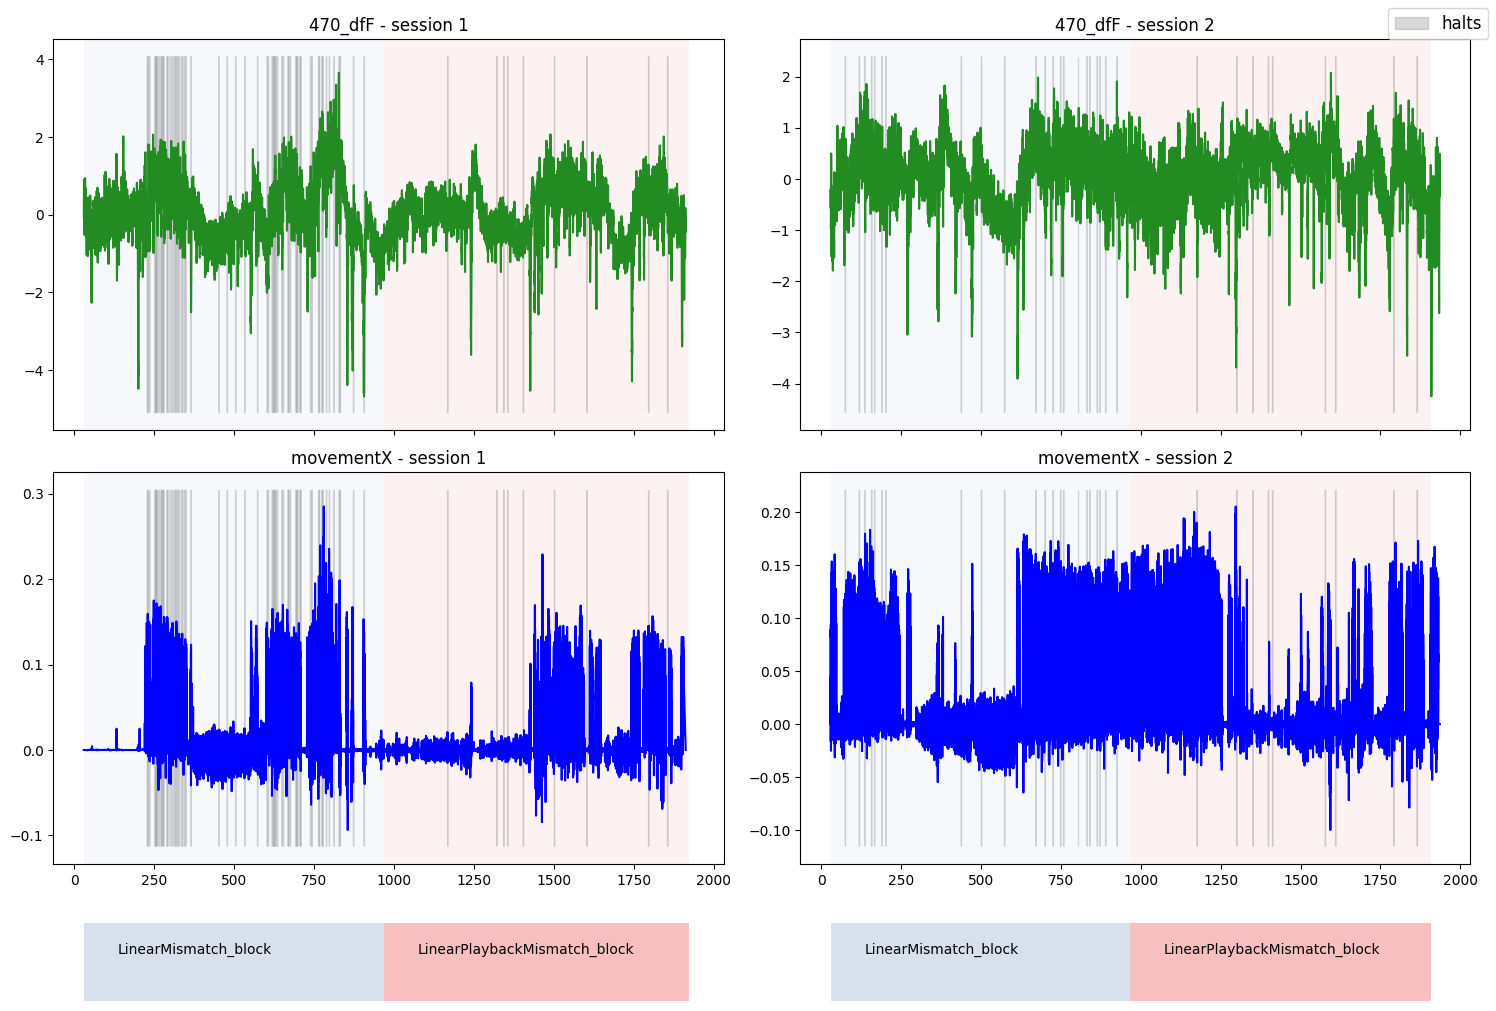

Plotted traces for B3M8


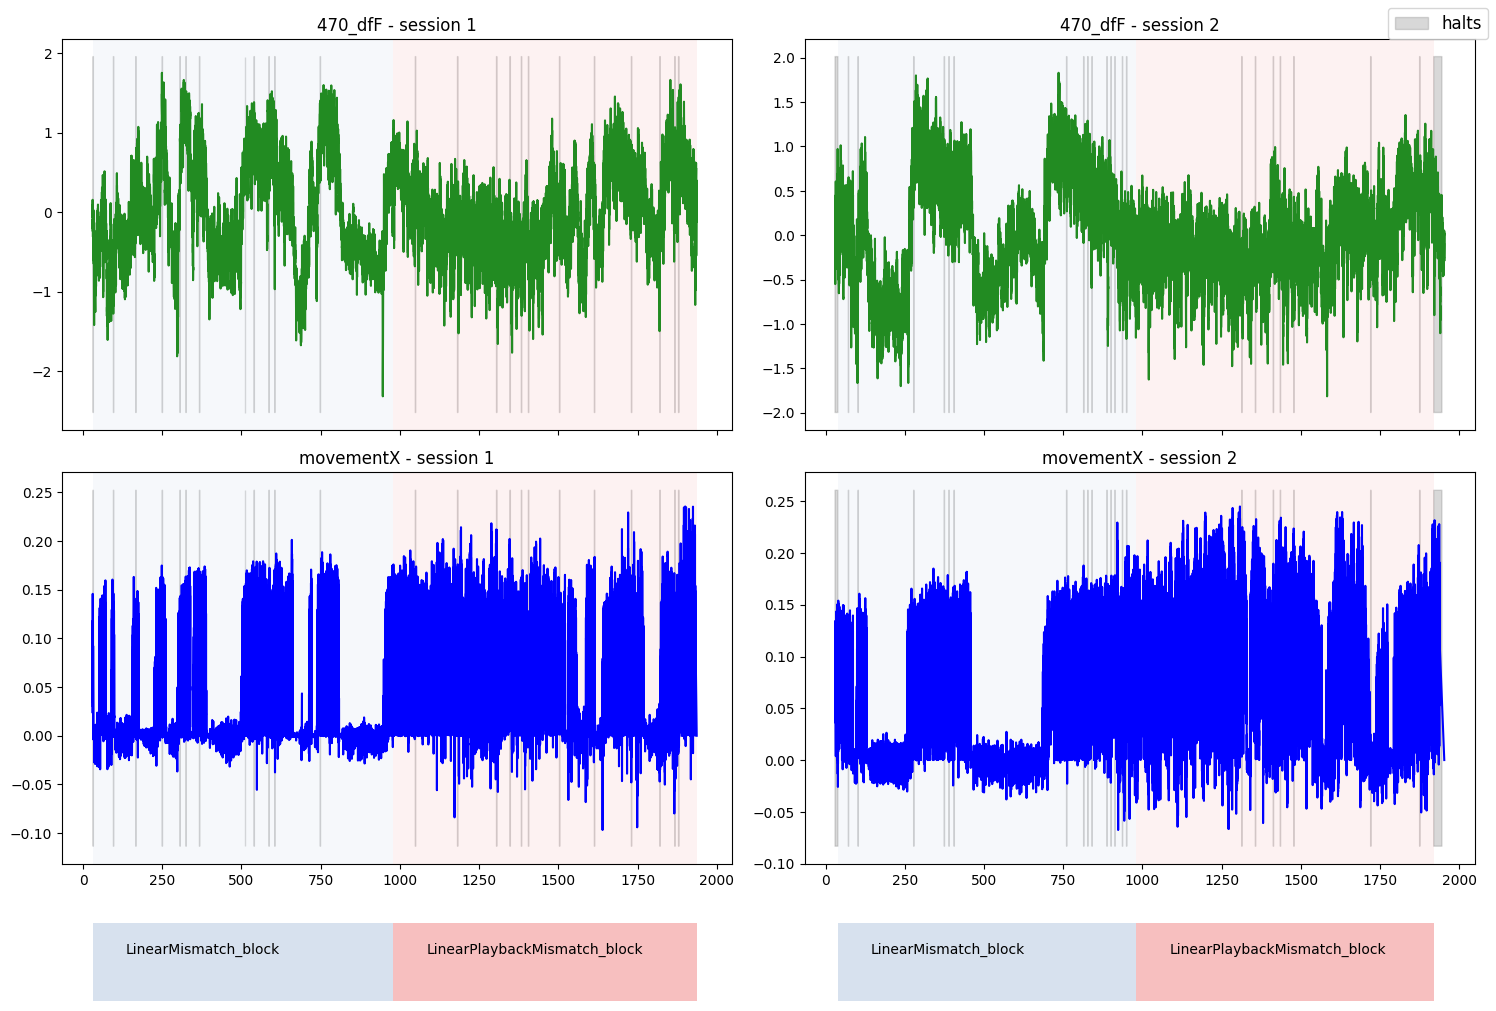

Plotted traces for B3M7


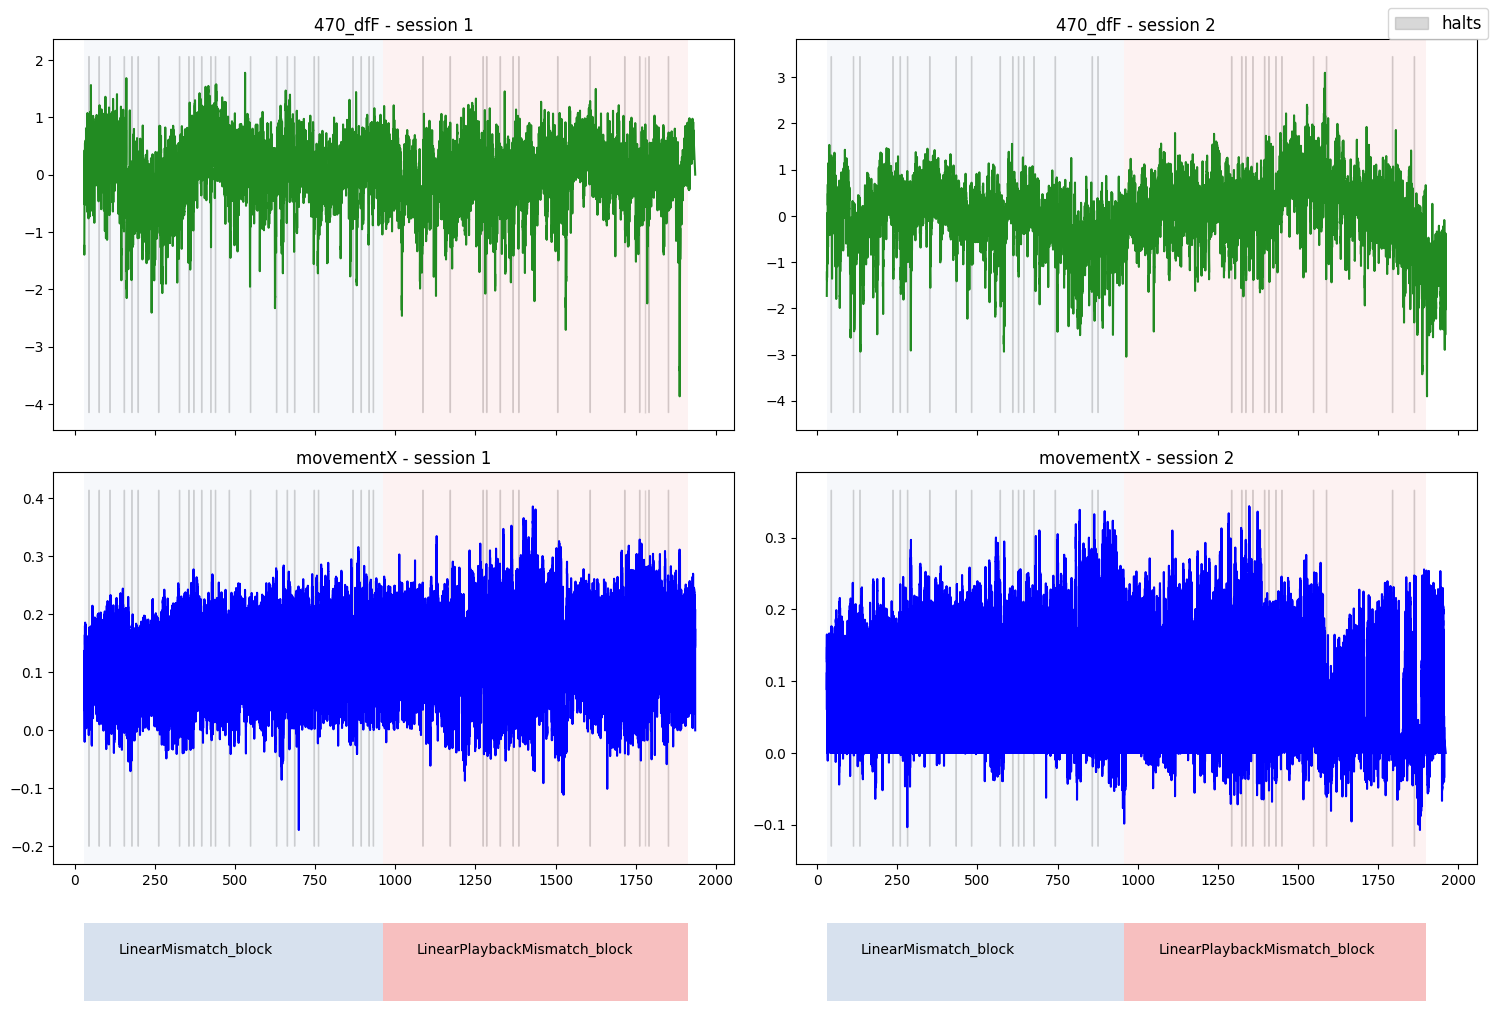

Plotted traces for B3M6


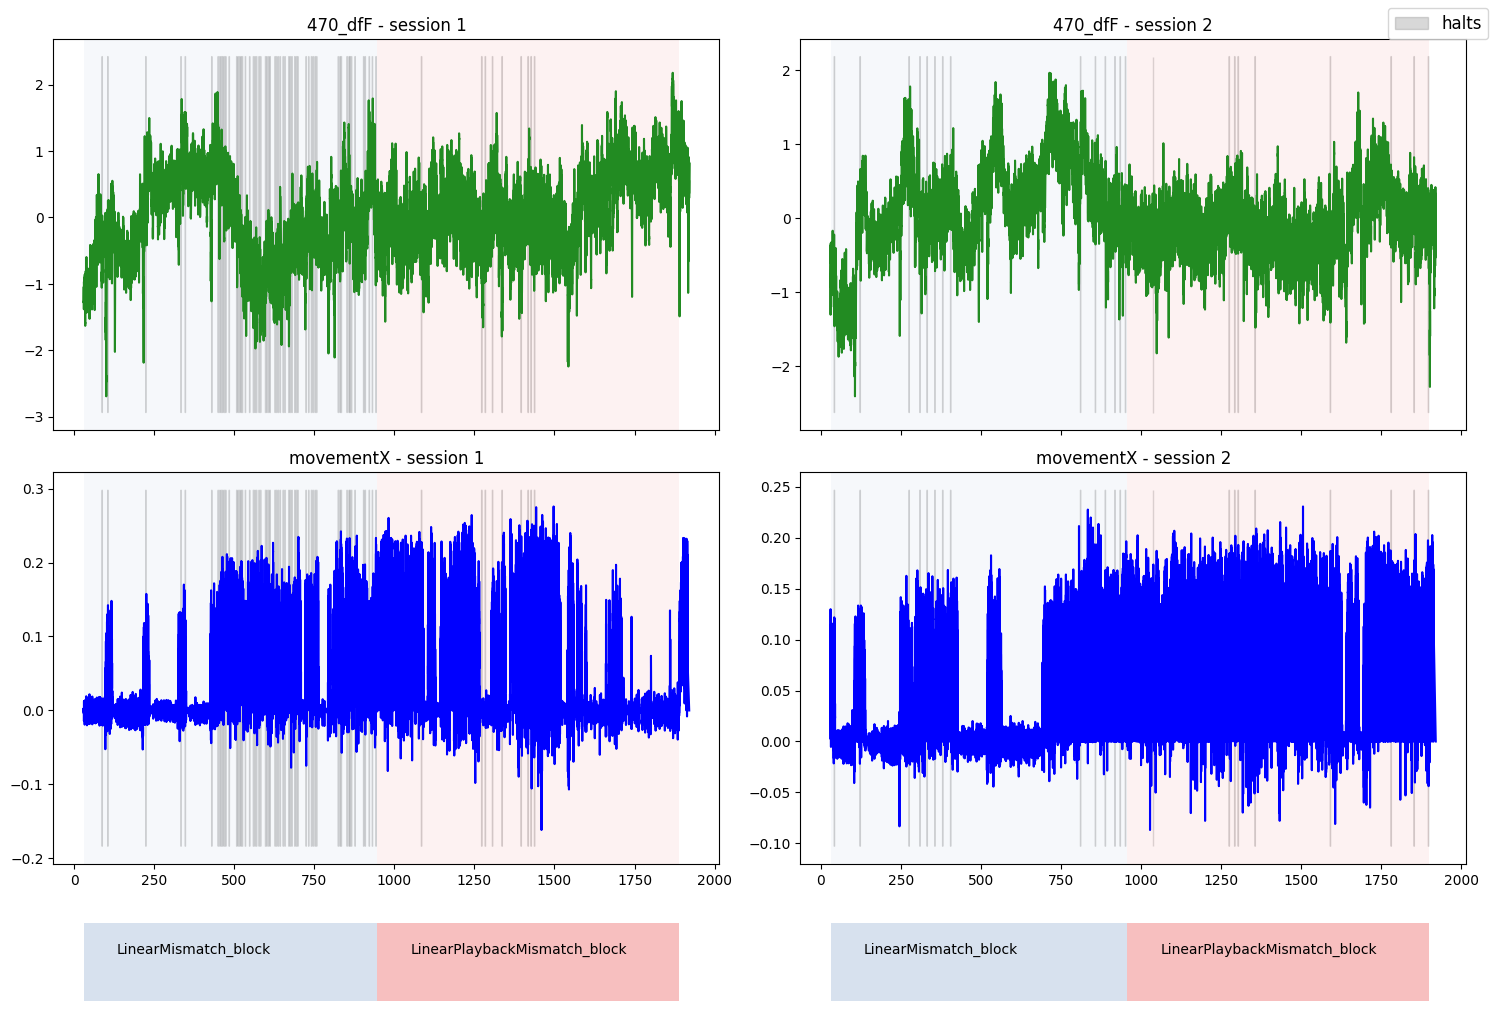

Plotted traces for B3M4


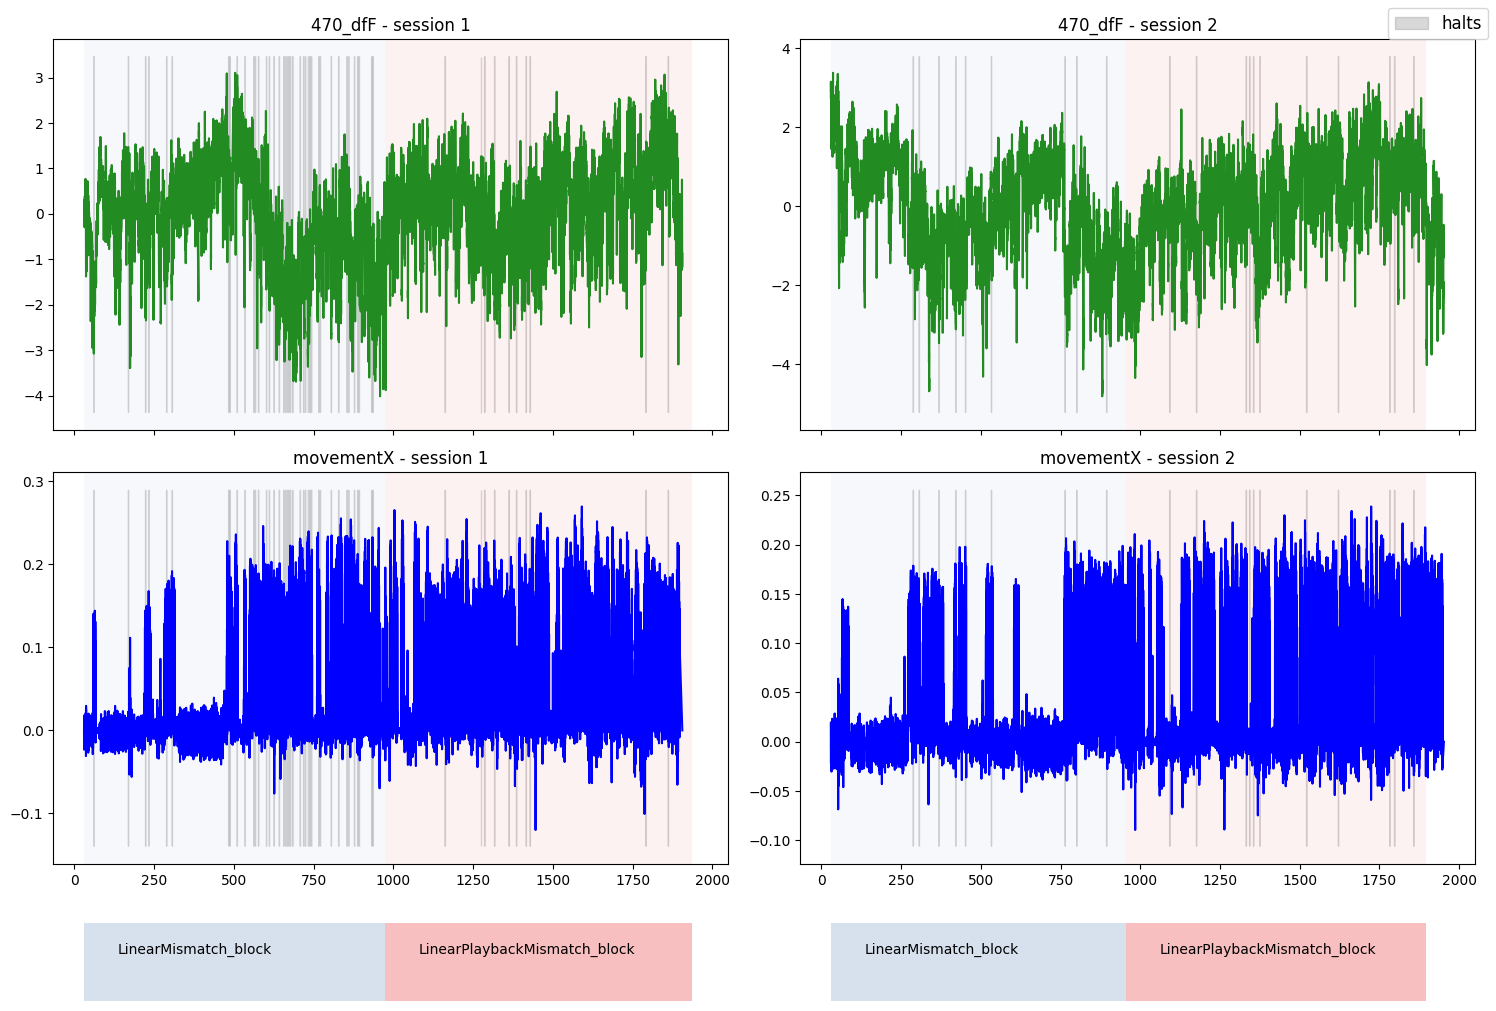

In [174]:
for mouse in Grab_MM_1.mouseID.unique():
    mousedata = {'session 1':Grab_MM_1.loc[Grab_MM_1.mouseID == mouse], 'session 2':Grab_MM_2.loc[Grab_MM_2.mouseID == mouse]}
    view_session_mouse(mousedata, mouse)

In [205]:
#Filter mice to get unique indexes
mouse_data = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for mouse in Grab_MM_1.mouseID.unique():
    mouse_data['session 1']['closedloop'][mouse] = filter_data(Grab_MM_1, filters = [mouse, 'closed_block'])
    mouse_data['session 1']['openloop'][mouse] = filter_data(Grab_MM_1, filters = [mouse, 'open_block'])
for mouse in Grab_MM_2.mouseID.unique():
    mouse_data['session 2']['closedloop'][mouse] = filter_data(Grab_MM_2, filters = [mouse, 'closed_block'])
    mouse_data['session 2']['openloop'][mouse] = filter_data(Grab_MM_2, filters = [mouse, 'open_block'])

In [206]:
#Aligning open and closed loop block data to halt start times
mouse_aligned = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged = align_to_event_start(df, '470_dfF', 'halt',[1,2])
            mouse_aligned[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt

    

In [207]:
mouse_aligned

{'session 1': {'closedloop': {'B2M6':          228.563   231.212   235.679   251.729   254.596   257.246   259.562  \
   -1.000  0.374837  0.152846  0.584142  0.614857  0.137341 -0.223938  0.063102   
   -0.999  0.377867  0.154157  0.576758  0.609607  0.136194 -0.226683  0.061543   
   -0.998  0.380897  0.155467  0.569374  0.604357  0.135122 -0.229428  0.059984   
   -0.997  0.383926  0.156777  0.561990  0.599107  0.134311 -0.232174  0.058425   
   -0.996  0.386956  0.158087  0.554606  0.593857  0.133521 -0.234919  0.056866   
   ...          ...       ...       ...       ...       ...       ...       ...   
    1.996 -0.087784  1.205397  1.939950 -0.202269  0.402429 -0.738378 -0.469162   
    1.997 -0.087421  1.203344  1.940468 -0.204306  0.406568 -0.741105 -0.473535   
    1.998 -0.087059  1.201291  1.940985 -0.206343  0.410707 -0.743831 -0.477909   
    1.999 -0.086696  1.199238  1.941503 -0.208379  0.414847 -0.746557 -0.482282   
    2.000 -0.086334  1.197185  1.942020 -0.210416  0

In [208]:
len(mouse_aligned['session 1']['closedloop'].keys())

5

In [213]:
mouse_aligned_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged = align_to_event_start(df, '470_dfF', 'No_halt',[1,2])
            mouse_aligned_nohalt[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt


In [215]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def plot_compare_blocks(block_dict, event):
    # Determine number of blocks (columns) and maximum number of mice (rows)
    num_blocks = len(block_dict)
    max_mice = max(len(mice_data) for mice_data in block_dict.values())
    
    # Set up the figure with the determined number of rows and columns
    fig, ax = plt.subplots(max_mice, num_blocks, figsize=(5 * num_blocks, 3 * max_mice), squeeze=False)
    fig.suptitle(f'{event} alignment')
    
    # Dictionary to store mean data across mice for each block
    mean_mouse_dict = {block: {} for block in block_dict.keys()}
    
    # Loop over each block and each mouse, plotting down the rows within each block column
    for col, (block_name, mice_data) in enumerate(block_dict.items()):
        color_map = plt.cm.Greys  # Grey color map for traces
        
        # Loop over each mouse in the current block
        for row, (mouse, data) in enumerate(mice_data.items()):
            color = color_map(np.linspace(0, 1, data.shape[1]))  # Assign colors for traces

            # Plot vertical line for event alignment
            ax[row, col].axvline(x=0, linewidth=1, color='r', linestyle='--')
            
            # Plot individual traces with shading
            for idx, trace in enumerate(data.columns):
                ax[row, col].plot(data.index, data[trace], color='grey', alpha=0.3)

            # Calculate mean and standard deviation across traces
            mean_trace = data.mean(axis=1)
            mean_mouse_dict[block_name][mouse] = mean_trace
            std_trace = data.std(axis=1)

            # Plot mean trace and standard deviation shading
            ax[row, col].plot(mean_trace, color='black', label='Mean' if row == 0 else "")
            ax[row, col].fill_between(mean_trace.index, mean_trace - std_trace, mean_trace + std_trace, alpha=0.3)

            # Add a shaded rectangle for a specified range (0 to 1)
            ax[row, col].add_patch(patches.Rectangle((0, ax[row, col].get_ylim()[0]), 1, 
                                                     ax[row, col].get_ylim()[1] - ax[row, col].get_ylim()[0], 
                                                     color='grey', alpha=0.1))
            # Set title and labels for the first row
            if row == 0:
                ax[row, col].set_title(f"{block_name} loop responses")
            if col == 0:
                ax[row, col].set_ylabel(f"Mouse: {mouse}")

    fig.tight_layout(pad=1.08)

    # Aggregate means across mice for each block
    fig, ax = plt.subplots(1, num_blocks, figsize=(5 * num_blocks, 5))
    fig.suptitle('Mean across animal means')
    
    for col, (block_name, mean_data) in enumerate(mean_mouse_dict.items()):
        # Create DataFrame from mean data and compute overall mean and std across mice
        mean_df = pd.DataFrame.from_dict(mean_data)
        overall_mean = mean_df.mean(axis=1)
        overall_std = mean_df.std(axis=1)
        
        # Plot mean across animals with standard deviation shading
        ax[col].axvline(x=0, linewidth=1, color='r', linestyle='--')
        ax[col].plot(overall_mean, color='black')
        ax[col].fill_between(overall_mean.index, overall_mean - overall_std, overall_mean + overall_std, alpha=0.3)
        
        # Add rectangle to highlight the specified region (e.g., 0 to 1)
        ax[col].add_patch(patches.Rectangle((0, ax[col].get_ylim()[0]), 1, 
                                            ax[col].get_ylim()[1] - ax[col].get_ylim()[0], 
                                            color='grey', alpha=0.1))
        
        # Set title for each block
        ax[col].set_title(f'{block_name} loop mean response')

    return mean_mouse_dict


In [ ]:
mean_mouse_dict_s1 =plot_compare_blocks(mouse_aligned['session 1'], 'halt')
mean_mouse_dict_s2 =plot_compare_blocks(mouse_aligned['session 2'], 'halt')

In [ ]:
mean_mouse_dict_s1_nohalt =plot_compare_blocks(mouse_aligned_nohalt['session 1'], 'No halt')

In [194]:
xtimes = [t for t in range(0, open_df.shape[0], round(open_df.shape[0] / 3))]
xtimes = [-1,0,1,2]

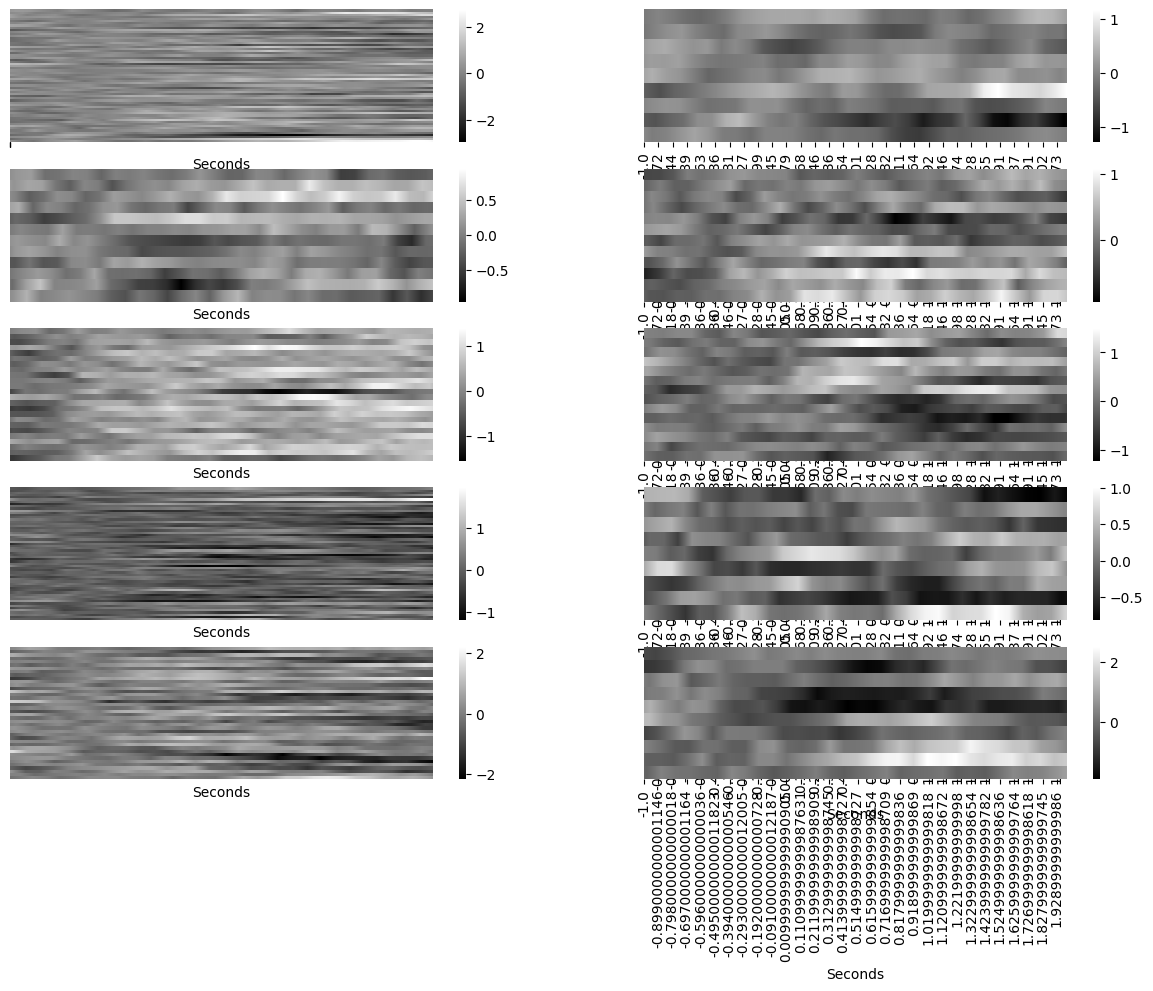

In [195]:
from matplotlib import ticker
fig, ax = plt.subplots(5,2, figsize =(15,10))
ax =ax.flatten()
i=0
for mouse, closed_df in aligned_closed.items():
    open_df = aligned_open[mouse]
    plot = sns.heatmap(closed_df.T, ax = ax[i], yticklabels=False,xticklabels=False, cmap='gray')
    plot = sns.heatmap(open_df.T, ax = ax[i+1],yticklabels=False, cmap='gray')
    ax[0].set_xticks(xtimes)
    #ax[0].set_xticklabels([t for t in range(-1, 3 + 1, 1)], rotation = 0)


    i+=2